Task: Predict whether a user will vote on another user's posting

**Considered datasets:**
* Network of Users Who Vote on Postings (undirected) - df_edge_list_undirected_users_votes_to_postings_net
* Network on Posting Behaviour of Users (undirected) - df_edge_list_undirected_users_postings_to_same_articles
* Network of Users Who Reply to Postings (directed) - df_edge_list_directed_users_postings_replies

**Additional datasets:**
* df_Postings_filtered_net - Probably would need this as well since we can filter out posting by their date
* df_Votes_filtered_net 

In [1]:
import node2vec
from node2vec import Node2Vec
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from linkpred import LinkPred
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np
import random
#maybe this one is better but don't import both Node2Vec at the same time!
#from torch_geometric.nn import Node2Vec 

In [6]:
folder_path = "./data"

In [7]:
# Directory containing your Parquet files
relative_path_to_data = folder_path
data_directory = os.path.abspath(relative_path_to_data)

# Desired file stems to load
desired_files = {
    "df_edge_list_undirected_users_votes_to_postings_net",
    "df_edge_list_undirected_users_postings_to_same_articles",
    "df_edge_list_directed_users_postings_replies",
    "df_Postings_filtered_net",
    "df_Votes_filtered_net"
}

# Dictionary to store DataFrames with stem names as keys
dataframes = {}

# Iterate over all Parquet files in the directory
for file_path in Path(data_directory).glob("*.parquet"):

    # Extract the file stem (name without extension)
    file_stem = file_path.stem
    
    # Check if the file stem is in the desired list
    if file_stem in desired_files:
        print(f"Reading file: {file_stem}")
        
        # Read the Parquet file into a DataFrame
        df = pd.read_parquet(file_path)
        
        # Store the DataFrame in the dictionary with the stem as the key
        dataframes[file_stem] = df

# Access DataFrames by their file stem
print(f"Loaded DataFrames: {list(dataframes.keys())}")

Reading file: df_edge_list_undirected_users_postings_to_same_articles
Reading file: df_edge_list_undirected_users_votes_to_postings_net
Reading file: df_Postings_filtered_net
Reading file: df_edge_list_directed_users_postings_replies
Reading file: df_Votes_filtered_net
Loaded DataFrames: ['df_edge_list_undirected_users_postings_to_same_articles', 'df_edge_list_undirected_users_votes_to_postings_net', 'df_Postings_filtered_net', 'df_edge_list_directed_users_postings_replies', 'df_Votes_filtered_net']


In [8]:
# Assign relevant DataFrames to new variable names
votes_to_postings = dataframes["df_edge_list_undirected_users_votes_to_postings_net"]
postings_to_articles = dataframes["df_edge_list_undirected_users_postings_to_same_articles"]
replies = dataframes["df_edge_list_directed_users_postings_replies"]

# Additional datasets
filtered_postings = dataframes["df_Postings_filtered_net"]
filtered_votes = dataframes["df_Votes_filtered_net"]

# Verify the updated key names in the dictionary
print("Updated DataFrame keys:", list(dataframes.keys()))

# Example access
print(votes_to_postings.head())  # View the first few rows of one of the DataFrames

Updated DataFrame keys: ['df_edge_list_undirected_users_postings_to_same_articles', 'df_edge_list_undirected_users_votes_to_postings_net', 'df_Postings_filtered_net', 'df_edge_list_directed_users_postings_replies', 'df_Votes_filtered_net']
   ID_CommunityIdentity_min  ID_CommunityIdentity_max  \
0                         4                      6293   
1                         4                      8008   
2                         4                      9525   
3                         4                     18764   
4                         4                     21088   

   count_votes_to_postings_net  
0                            1  
1                            1  
2                            1  
3                            1  
4                            1  


We decided to experiment with the following dataframes for link prediction:
- "df_edge_list_undirected_users_votes_to_postings_net"

In [9]:
print("Undirected Votes DataFrame Info:")
print(votes_to_postings.info(), "\n")

Undirected Votes DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5535637 entries, 0 to 5535636
Data columns (total 3 columns):
 #   Column                       Dtype
---  ------                       -----
 0   ID_CommunityIdentity_min     int64
 1   ID_CommunityIdentity_max     int64
 2   count_votes_to_postings_net  int64
dtypes: int64(3)
memory usage: 126.7 MB
None 



In [10]:
print("Missing Data in Undirected Replies:")
print(votes_to_postings.isnull().sum(), "\n")

Missing Data in Undirected Replies:
ID_CommunityIdentity_min       0
ID_CommunityIdentity_max       0
count_votes_to_postings_net    0
dtype: int64 



In [11]:
print("\nPreview of DataFrame:")
display(votes_to_postings.head())


Preview of DataFrame:


,ID_CommunityIdentity_min,ID_CommunityIdentity_max,count_votes_to_postings_net
0,4,6293,1
1,4,8008,1
2,4,9525,1
3,4,18764,1
4,4,21088,1


### Link Prediction

First we experiment with the directed version

In [12]:
# Convert the undirected votes dataset into a graph
G_undirected = nx.from_pandas_edgelist(
    votes_to_postings,  # Replace with your DataFrame variable
    source="ID_CommunityIdentity_min",
    target="ID_CommunityIdentity_max",
    edge_attr="count_votes_to_postings_net",  # Optional: edge weights
    create_using=nx.Graph()  # Ensure an undirected graph
)


In [23]:
import pickle

# Load the graph
with open("graph.pkl", "rb") as f:
    G_undirected = pickle.load(f)

# Verify the graph is loaded
print(f"Graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")


Graph: 10964 nodes, 529434 edges


In [24]:
# check if its directed
G_undirected.is_directed()


False

In [25]:
# create subgraph

# Sample a smaller subgraph
subgraph = G_undirected.subgraph(list(G_undirected.nodes)[:1000])  # Adjust size 

# G_directed = subgraph # comment it out when using the full graph


In [26]:
#check number of nodes
subgraph.number_of_nodes()

1000

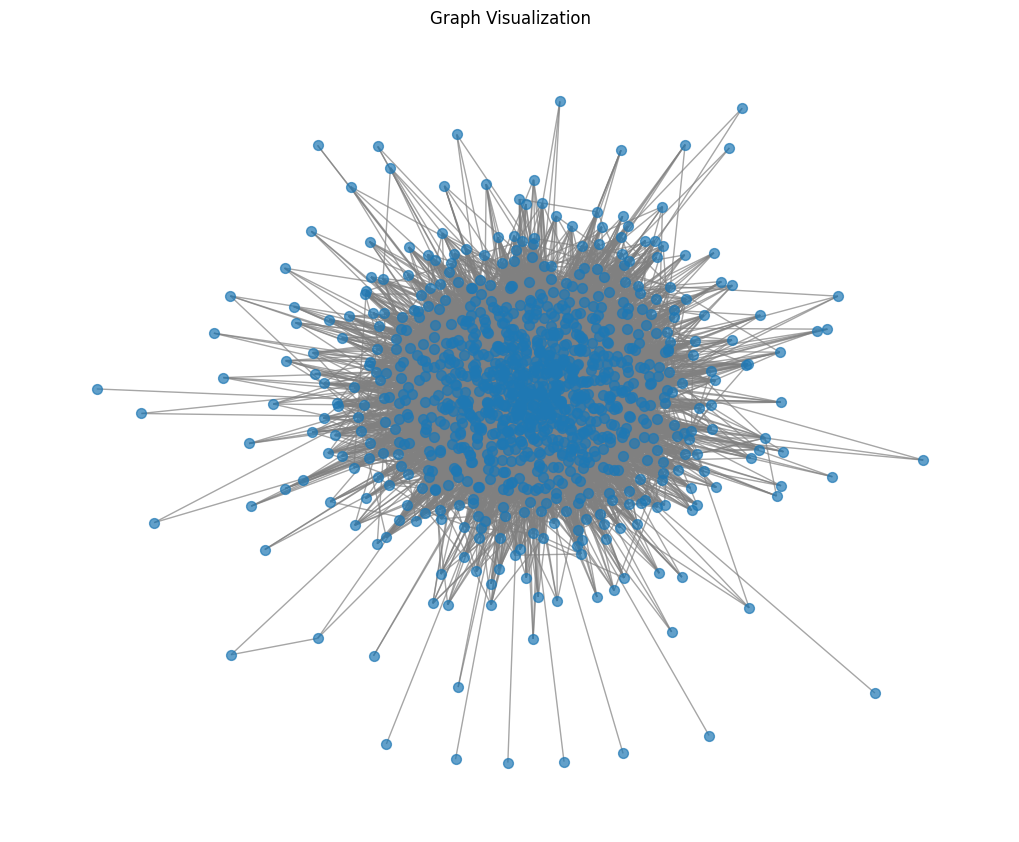

In [27]:
# Visualize the subgraph with basic layout
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph) 
nx.draw(
    subgraph, 
    pos, 
    with_labels=False, 
    node_size=50, 
    edge_color='gray', 
    alpha=0.7
)
plt.title("Graph Visualization")
plt.show()

### Train Test and Validation Split

In [28]:
graph = subgraph # comment it out when using the full
# graph = G_undirected # comment it out when using the subgraph

In [29]:
len(graph.edges)

35141

In [30]:
# 1. Extract all edges (positive examples)
edges = list(graph.edges())

# 2. Split edges into train/test (85% train+val, 15% test)
train_val_edges, test_edges = train_test_split(edges, test_size=0.15, random_state=42)

# 3. Split train_val into train (70%) and validation (15%)
train_edges, val_edges = train_test_split(train_val_edges, test_size=0.1765, random_state=42)  # 0.1765 ≈ 15% of 85%

# 4. Create the train graph (only training edges)
graph_train = graph.copy()
graph_train.remove_edges_from(val_edges)
graph_train.remove_edges_from(test_edges)

# Ensure all nodes from the original graph are in the train graph
graph_train.add_nodes_from(graph.nodes())

# Print statistics
print(f"Original Graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")
print(f"Train Graph: {graph_train.number_of_nodes()} nodes, {graph_train.number_of_edges()} edges")
print(f"Training Edges: {len(train_edges)}")
print(f"Validation Edges: {len(val_edges)}")
print(f"Test Edges: {len(test_edges)}")

Original Graph: 1000 nodes, 35141 edges
Train Graph: 1000 nodes, 24597 edges
Training Edges: 24597
Validation Edges: 5272
Test Edges: 5272


In [32]:
# Generate negative edges (non-edges)
all_non_edges = set(nx.non_edges(graph))

# Sample negative edges for each set
#train_neg_edges = random.sample(all_non_edges, len(train_edges))
#val_neg_edges = random.sample(all_non_edges - set(train_neg_edges), len(val_edges))
#test_neg_edges = random.sample(all_non_edges - set(train_neg_edges) - set(val_neg_edges), len(test_edges))
train_neg_edges = random.sample(list(all_non_edges), len(train_edges))
val_neg_edges = random.sample(list(all_non_edges - set(train_neg_edges)), len(val_edges))
test_neg_edges = random.sample(list(all_non_edges - set(train_neg_edges) - set(val_neg_edges)), len(test_edges))

# Verify counts
print(f"Train Negative Edges: {len(train_neg_edges)}")
print(f"Validation Negative Edges: {len(val_neg_edges)}")
print(f"Test Negative Edges: {len(test_neg_edges)}")



Train Negative Edges: 24597
Validation Negative Edges: 5272
Test Negative Edges: 5272


### Train and evaluate link prediction model using node2vec

In [33]:
# Calculate node embeddings with Node2Vec on the training graph

node2vec_train = Node2Vec(
    graph=graph_train, # Use the training graph
    dimensions=64,    # Embedding dimensions
    walk_length=30,   # Length of random walks
    num_walks=200,    # Number of random walks per node
    workers=4         # Parallel threads
)

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

python(66553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66554) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66555) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66556) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Generating walks (CPU: 4): 100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


In [34]:
# Fit the model and extract embeddings
model_train = node2vec_train.fit()
embeddings_train = {node: model_train.wv[str(node)] for node in graph_train.nodes()}

# Verify embeddings
print(f"Number of nodes in train_graph: {graph_train.number_of_nodes()}")
print(f"Number of generated embeddings: {len(embeddings_train)}")

Number of nodes in train_graph: 1000
Number of generated embeddings: 1000


In [35]:
def embedding_train(node):
    return model_train.wv[str(node)]

In [36]:
# verify embeddings
for node in list(graph_train.nodes())[:5]:
    print(f"Node {node}: {embeddings_train[node]}")

Node 163840: [ 3.9033608e-03  3.1609783e-01  3.8595703e-01 -3.7781972e-01
  1.6085064e-01 -4.9111670e-01  1.0333448e-01 -3.3475101e-01
  5.4327452e-01 -2.5925040e-02  4.6307978e-01 -6.8850517e-03
 -3.1595632e-01 -2.4702625e-01 -6.0632157e-01  2.2359005e-01
 -3.6730659e-01 -2.6511234e-01  6.2293369e-01 -1.1018611e-01
  2.8500247e-01  2.9018372e-01 -2.6538241e-01 -1.7306302e-01
 -1.4858195e-01 -3.2038453e-01 -4.8197603e-01  1.4216164e-01
 -7.1050197e-01  5.6287110e-02  3.8894981e-01  2.7515602e-01
 -2.7079171e-01 -3.7418619e-01 -4.2923108e-02 -2.3889139e-01
  5.1933992e-01 -4.2190099e-01  3.5451877e-01 -1.0823528e-01
 -1.0754263e-01  1.3765094e-01 -4.9247991e-02 -7.6371968e-02
  1.5122569e-01  9.9927299e-02  1.3428982e-01  1.0322106e-01
 -3.2648182e-01  5.7745498e-02 -1.3972071e-01 -6.8192855e-02
 -5.4593280e-02  3.4103048e-01 -6.0450979e-02  2.3301563e-01
  4.7947068e-02 -4.9220347e-01  9.0973511e-02  5.0849700e-05
 -6.0414308e-01 -5.6280089e-03  5.5753928e-01  2.2987881e-01]
Node 53453

In [37]:
# Define binary operators
def operator_hadamard(u, v):
    return u * v  # Element-wise product

def operator_l1(u, v):
    return np.abs(u - v)  # L1 distance

def operator_l2(u, v):
    return (u - v) ** 2  # L2 distance

def operator_avg(u, v):
    return (u + v) / 2  # Average

# List of operators
binary_operators = {
    "Hadamard": operator_hadamard,
    "L1": operator_l1,
    "L2": operator_l2,
    "Average": operator_avg
}

In [38]:
# Generate features for positive training edges
X_train_pos = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in train_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Generate features for negative training edges
X_train_neg = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in train_neg_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Combine features
X_train = np.vstack([X_train_pos, X_train_neg])  # Combine positive and negative features
y_train = [1] * len(X_train_pos) + [0] * len(X_train_neg)  # Labels: 1 for positive, 0 for negative

# Verify outputs
print(f"Train Features: {len(X_train)}, Positive Edges: {len(X_train_pos)}, Negative Edges: {len(X_train_neg)}")

Train Features: 49194, Positive Edges: 24597, Negative Edges: 24597


In [39]:
# Generate features for positive validation edges
X_val_pos = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in val_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Generate features for negative validation edges
X_val_neg = [
    operator_hadamard(embedding_train(u), embedding_train(v)) 
    for u, v in val_neg_edges if str(u) in model_train.wv and str(v) in model_train.wv
]

# Combine features
X_val = np.vstack([X_val_pos, X_val_neg])  # Combine positive and negative features
y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)  # Labels: 1 for positive, 0 for negative

# Verify outputs
print(f"Validation Features: {len(X_val)}, Positive Edges: {len(X_val_pos)}, Negative Edges: {len(X_val_neg)}")

Validation Features: 10544, Positive Edges: 5272, Negative Edges: 5272


In [40]:
# Train the logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [41]:
# Predict probabilities for the validation set
y_val_proba = clf.predict_proba(X_val)[:, 1]  # Probability of the positive class (1)

# Compute ROC AUC
val_auc = roc_auc_score(y_val, y_val_proba)

print(f"Validation ROC AUC: {val_auc:.4f}")

Validation ROC AUC: 0.5238


### Evaluate the best model using the test set 

In [43]:
graph_test = graph.copy()  # Replace `graph` with your main graph variable
graph_test.remove_edges_from(train_edges + val_edges)

In [44]:
# Train Node2Vec on the test graph
node2vec_test = Node2Vec(
    graph_test,  # Use the test graph
    dimensions=64,
    walk_length=30,
    num_walks=200,
    workers=4
)

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

python(66708) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66709) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66710) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66711) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Generating walks (CPU: 4): 100%|██████████| 50/50 [00:03<00:00, 14.17it/s]


In [45]:
model_test = node2vec_test.fit()

# Create a function to retrieve test embeddings
def embedding_test(node):
    return model_test.wv[str(node)]

In [46]:
# Generate features for test edges (positive and negative)
X_test_pos = [operator_avg(embedding_test(u), embedding_test(v)) for u, v in test_edges]
X_test_neg = [operator_avg(embedding_test(u), embedding_test(v)) for u, v in test_neg_edges]

# Combine features and labels
X_test = np.vstack([X_test_pos, X_test_neg])
y_test = [1] * len(test_edges) + [0] * len(test_neg_edges)

In [47]:
# Predict probabilities and labels for the test set
y_test_proba = clf.predict_proba(X_test)[:, 1]
y_test_pred = clf.predict(X_test)

# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.5207
Test ROC AUC: 0.5028


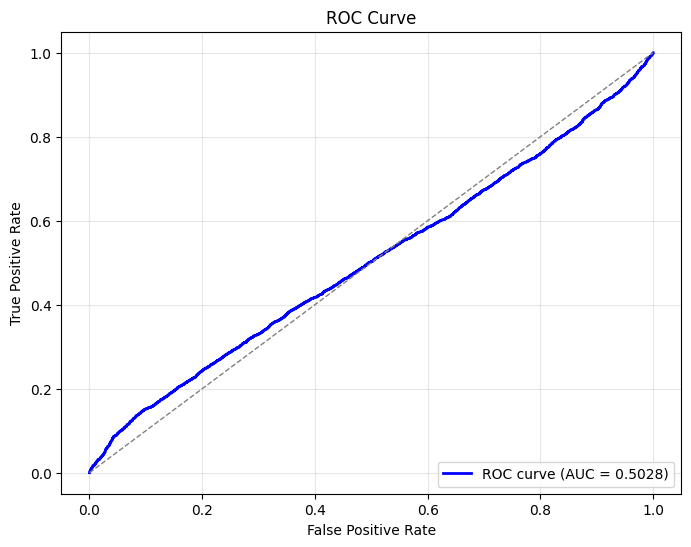

In [48]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Tune Node2vec

#### Helper fucntion for the genrator and operator

In [50]:
# Define the operator
def operator_hadamard(embedding1, embedding2):
    """
    Computes the Hadamard operator (element-wise product) for two embeddings.
    """
    return embedding1 * embedding2

# Define the feature generator
def generate_features_with_operator(edges, embeddings, operator):
    """
    Generates features for a set of edges using the given operator and embeddings.
    """
    features = []
    for edge in edges:
        source, target = edge
        source_embedding = embeddings[source]
        target_embedding = embeddings[target]
        features.append(operator(source_embedding, target_embedding))
    return np.array(features)


In [51]:
def train_node2vec(graph, dimensions, walk_length, num_walks, p, q):
    """
    Trains a Node2Vec model and returns the learned embeddings.
    """
    node2vec = Node2Vec(
        graph=graph,
        dimensions=dimensions,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=4,
        p=p,
        q=q
    )
    model = node2vec.fit()
    embeddings = {node: model.wv[str(node)] for node in graph.nodes()}
    return embeddings


In [57]:
def evaluate_on_validation_set(clf, embeddings, val_edges, val_neg_edges):
    """
    Evaluates the classifier on the validation set and computes the ROC AUC.
    """
    # Generate features
    X_val_pos = generate_features_with_operator(val_edges, embeddings, operator_hadamard)
    X_val_neg = generate_features_with_operator(val_neg_edges, embeddings, operator_hadamard)

    X_val = np.vstack([X_val_pos, X_val_neg])
    y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)
    
    # Predict probabilities
    y_val_proba = clf.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, y_val_proba)
    return val_auc


In [75]:
from itertools import product

def tune_parameters(graph_train, X_train, y_train, val_edges, val_neg_edges, dimensions=64):
    walk_length_list = [10, 20, 30]
    num_walks_list = [10, 20, 50]
    p_list = [0.5, 1, 2]
    q_list = [0.5, 1, 2]

    best_auc = 0
    best_params = None

    for walk_length, num_walks, p, q in product(walk_length_list, num_walks_list, p_list, q_list):
        print(f"Testing: dimensions={dimensions}, walk_length={walk_length}, num_walks={num_walks}, p={p}, q={q}")

        # Train Node2Vec with current parameters
        node2vec = Node2Vec(
            graph=graph_train,
            dimensions=dimensions,  # Fixed dimensions
            walk_length=walk_length,
            num_walks=num_walks,
            workers=4,
            p=p,
            q=q
        )
        model = node2vec.fit()
        embeddings = {node: model.wv[str(node)] for node in graph_train.nodes()}

        # Generate validation features
        X_val_pos = [
            operator_hadamard(embeddings[u], embeddings[v])
            for u, v in val_edges if str(u) in model.wv and str(v) in model.wv
        ]
        X_val_neg = [
            operator_hadamard(embeddings[u], embeddings[v])
            for u, v in val_neg_edges if str(u) in model.wv and str(v) in model.wv
        ]
        X_val = np.vstack([X_val_pos, X_val_neg])
        y_val = [1] * len(X_val_pos) + [0] * len(X_val_neg)

        # Train logistic regression classifier
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train, y_train)

        # Evaluate on validation set
        y_val_proba = clf.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, y_val_proba)
        print(f"Validation ROC AUC: {val_auc:.4f}")

        # Update best parameters if necessary
        if val_auc > best_auc:
            best_auc = val_auc
            best_params = (walk_length, num_walks, p, q)

    print(f"\nBest Parameters: walk_length={best_params[0]}, num_walks={best_params[1]}, p={best_params[2]}, q={best_params[3]}")
    print(f"Best Validation ROC AUC: {best_auc:.4f}")
    return best_params, best_auc


In [76]:
# Run parameter tuning
best_params, best_auc = tune_parameters(graph_train, X_train, y_train, val_edges, val_neg_edges)


Testing: dimensions=64, walk_length=10, num_walks=10, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 20.74it/s]


Validation ROC AUC: 0.5512
Testing: dimensions=64, walk_length=10, num_walks=10, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 19.77it/s]


Validation ROC AUC: 0.5695
Testing: dimensions=64, walk_length=10, num_walks=10, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 17.22it/s]


Validation ROC AUC: 0.5725
Testing: dimensions=64, walk_length=10, num_walks=10, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 20.18it/s]


Validation ROC AUC: 0.5544
Testing: dimensions=64, walk_length=10, num_walks=10, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 19.72it/s]


Validation ROC AUC: 0.5647
Testing: dimensions=64, walk_length=10, num_walks=10, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 17.35it/s]


Validation ROC AUC: 0.5894
Testing: dimensions=64, walk_length=10, num_walks=10, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 19.04it/s]


Validation ROC AUC: 0.5544
Testing: dimensions=64, walk_length=10, num_walks=10, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 19.92it/s]


Validation ROC AUC: 0.5867
Testing: dimensions=64, walk_length=10, num_walks=10, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 19.46it/s]


Validation ROC AUC: 0.5865
Testing: dimensions=64, walk_length=10, num_walks=20, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 20.87it/s]


Validation ROC AUC: 0.5310
Testing: dimensions=64, walk_length=10, num_walks=20, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 20.41it/s]


Validation ROC AUC: 0.5349
Testing: dimensions=64, walk_length=10, num_walks=20, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 19.90it/s]


Validation ROC AUC: 0.5452
Testing: dimensions=64, walk_length=10, num_walks=20, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 20.63it/s]


Validation ROC AUC: 0.5263
Testing: dimensions=64, walk_length=10, num_walks=20, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 18.95it/s]


Validation ROC AUC: 0.5299
Testing: dimensions=64, walk_length=10, num_walks=20, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 19.74it/s]


Validation ROC AUC: 0.5395
Testing: dimensions=64, walk_length=10, num_walks=20, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 20.52it/s]


Validation ROC AUC: 0.5591
Testing: dimensions=64, walk_length=10, num_walks=20, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 20.28it/s]


Validation ROC AUC: 0.5455
Testing: dimensions=64, walk_length=10, num_walks=20, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00, 19.57it/s]


Validation ROC AUC: 0.5330
Testing: dimensions=64, walk_length=10, num_walks=50, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 20.23it/s]


Validation ROC AUC: 0.4869
Testing: dimensions=64, walk_length=10, num_walks=50, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 20.06it/s]


Validation ROC AUC: 0.4933
Testing: dimensions=64, walk_length=10, num_walks=50, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 15.69it/s]


Validation ROC AUC: 0.4750
Testing: dimensions=64, walk_length=10, num_walks=50, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 19.60it/s]


Validation ROC AUC: 0.4905
Testing: dimensions=64, walk_length=10, num_walks=50, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 19.07it/s]


Validation ROC AUC: 0.4961
Testing: dimensions=64, walk_length=10, num_walks=50, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 18.17it/s]


Validation ROC AUC: 0.4940
Testing: dimensions=64, walk_length=10, num_walks=50, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 20.17it/s]


Validation ROC AUC: 0.4877
Testing: dimensions=64, walk_length=10, num_walks=50, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 19.25it/s]


Validation ROC AUC: 0.4935
Testing: dimensions=64, walk_length=10, num_walks=50, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:00<00:00, 18.56it/s]


Validation ROC AUC: 0.5095
Testing: dimensions=64, walk_length=20, num_walks=10, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.54it/s]


Validation ROC AUC: 0.5459
Testing: dimensions=64, walk_length=20, num_walks=10, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


Validation ROC AUC: 0.5341
Testing: dimensions=64, walk_length=20, num_walks=10, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Validation ROC AUC: 0.5356
Testing: dimensions=64, walk_length=20, num_walks=10, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Validation ROC AUC: 0.5304
Testing: dimensions=64, walk_length=20, num_walks=10, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


Validation ROC AUC: 0.5427
Testing: dimensions=64, walk_length=20, num_walks=10, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


Validation ROC AUC: 0.5213
Testing: dimensions=64, walk_length=20, num_walks=10, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]


Validation ROC AUC: 0.5506
Testing: dimensions=64, walk_length=20, num_walks=10, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Validation ROC AUC: 0.5510
Testing: dimensions=64, walk_length=20, num_walks=10, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Validation ROC AUC: 0.5405
Testing: dimensions=64, walk_length=20, num_walks=20, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  9.50it/s]


Validation ROC AUC: 0.4957
Testing: dimensions=64, walk_length=20, num_walks=20, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  8.92it/s]


Validation ROC AUC: 0.4936
Testing: dimensions=64, walk_length=20, num_walks=20, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  8.79it/s]


Validation ROC AUC: 0.5020
Testing: dimensions=64, walk_length=20, num_walks=20, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Validation ROC AUC: 0.4955
Testing: dimensions=64, walk_length=20, num_walks=20, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  9.32it/s]


Validation ROC AUC: 0.4911
Testing: dimensions=64, walk_length=20, num_walks=20, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Validation ROC AUC: 0.4864
Testing: dimensions=64, walk_length=20, num_walks=20, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  9.58it/s]


Validation ROC AUC: 0.4932
Testing: dimensions=64, walk_length=20, num_walks=20, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  8.82it/s]


Validation ROC AUC: 0.5048
Testing: dimensions=64, walk_length=20, num_walks=20, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  8.85it/s]


Validation ROC AUC: 0.5189
Testing: dimensions=64, walk_length=20, num_walks=50, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  8.48it/s]


Validation ROC AUC: 0.4783
Testing: dimensions=64, walk_length=20, num_walks=50, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]


Validation ROC AUC: 0.4798
Testing: dimensions=64, walk_length=20, num_walks=50, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  7.80it/s]


Validation ROC AUC: 0.4905
Testing: dimensions=64, walk_length=20, num_walks=50, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  8.34it/s]


Validation ROC AUC: 0.4719
Testing: dimensions=64, walk_length=20, num_walks=50, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


Validation ROC AUC: 0.4882
Testing: dimensions=64, walk_length=20, num_walks=50, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  7.77it/s]


Validation ROC AUC: 0.5081
Testing: dimensions=64, walk_length=20, num_walks=50, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Validation ROC AUC: 0.4925
Testing: dimensions=64, walk_length=20, num_walks=50, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  8.01it/s]


Validation ROC AUC: 0.4944
Testing: dimensions=64, walk_length=20, num_walks=50, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:01<00:00,  6.50it/s]


Validation ROC AUC: 0.4994
Testing: dimensions=64, walk_length=30, num_walks=10, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


Validation ROC AUC: 0.5121
Testing: dimensions=64, walk_length=30, num_walks=10, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


Validation ROC AUC: 0.5039
Testing: dimensions=64, walk_length=30, num_walks=10, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Validation ROC AUC: 0.5143
Testing: dimensions=64, walk_length=30, num_walks=10, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Validation ROC AUC: 0.5167
Testing: dimensions=64, walk_length=30, num_walks=10, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


Validation ROC AUC: 0.5006
Testing: dimensions=64, walk_length=30, num_walks=10, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


Validation ROC AUC: 0.5049
Testing: dimensions=64, walk_length=30, num_walks=10, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


Validation ROC AUC: 0.5178
Testing: dimensions=64, walk_length=30, num_walks=10, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Validation ROC AUC: 0.5045
Testing: dimensions=64, walk_length=30, num_walks=10, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Validation ROC AUC: 0.5299
Testing: dimensions=64, walk_length=30, num_walks=20, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Validation ROC AUC: 0.4829
Testing: dimensions=64, walk_length=30, num_walks=20, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Validation ROC AUC: 0.4865
Testing: dimensions=64, walk_length=30, num_walks=20, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.36it/s]


Validation ROC AUC: 0.4899
Testing: dimensions=64, walk_length=30, num_walks=20, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Validation ROC AUC: 0.5051
Testing: dimensions=64, walk_length=30, num_walks=20, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Validation ROC AUC: 0.4911
Testing: dimensions=64, walk_length=30, num_walks=20, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Validation ROC AUC: 0.5096
Testing: dimensions=64, walk_length=30, num_walks=20, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


Validation ROC AUC: 0.5105
Testing: dimensions=64, walk_length=30, num_walks=20, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


Validation ROC AUC: 0.4909
Testing: dimensions=64, walk_length=30, num_walks=20, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [00:00<00:00,  5.41it/s]


Validation ROC AUC: 0.5135
Testing: dimensions=64, walk_length=30, num_walks=50, p=0.5, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  5.14it/s]


Validation ROC AUC: 0.4932
Testing: dimensions=64, walk_length=30, num_walks=50, p=0.5, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.76it/s]


Validation ROC AUC: 0.4863
Testing: dimensions=64, walk_length=30, num_walks=50, p=0.5, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.32it/s]


Validation ROC AUC: 0.4883
Testing: dimensions=64, walk_length=30, num_walks=50, p=1, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.56it/s]


Validation ROC AUC: 0.4912
Testing: dimensions=64, walk_length=30, num_walks=50, p=1, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.88it/s]


Validation ROC AUC: 0.4852
Testing: dimensions=64, walk_length=30, num_walks=50, p=1, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


Validation ROC AUC: 0.4924
Testing: dimensions=64, walk_length=30, num_walks=50, p=2, q=0.5


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Validation ROC AUC: 0.4901
Testing: dimensions=64, walk_length=30, num_walks=50, p=2, q=1


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.90it/s]


Validation ROC AUC: 0.4798
Testing: dimensions=64, walk_length=30, num_walks=50, p=2, q=2


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


Validation ROC AUC: 0.4843

Best Parameters: walk_length=10, num_walks=10, p=1, q=2
Best Validation ROC AUC: 0.5894


### Train with Best Parameters

In [77]:
# Unpack the best parameters
best_walk_length, best_num_walks, best_p, best_q = best_params

# Train Node2Vec using the best parameters
node2vec_final = Node2Vec(
    graph=graph_train,
    dimensions=64,  # Same dimensions as during tuning
    walk_length=best_walk_length,
    num_walks=best_num_walks,
    workers=4,
    p=best_p,
    q=best_q
)
model_final = node2vec_final.fit()
embeddings_final = {node: model_final.wv[str(node)] for node in graph_train.nodes()}


Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

python(68343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68346) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 16.74it/s]


In [ ]:
# Generate features for test set
X_test_pos = [
    operator_hadamard(embeddings_final[u], embeddings_final[v])
    for u, v in test_edges if str(u) in model_final.wv and str(v) in model_final.wv
]
X_test_neg = [
    operator_hadamard(embeddings_final[u], embeddings_final[v])
    for u, v in test_neg_edges if str(u) in model_final.wv and str(v) in model_final.wv
]
X_test = np.vstack([X_test_pos, X_test_neg])
y_test = [1] * len(X_test_pos) + [0] * len(X_test_neg)
